In [3]:
import pandas as pd

# Step 1: Load Dataset + Initial Cleaning

# Load dataset
df = pd.read_csv("telco_churn.csv")

# View structure
print(df.shape)
df.head()

df.info()
df.describe()
df.isnull().sum()
# Convert 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check missing values again
print(df.isnull().sum())

# Drop rows with missing 'TotalCharges'
df.dropna(inplace=True)

# Reset index (optional)
df.reset_index(drop=True, inplace=True)
# Drop customerID (not useful)
df.drop('customerID', axis=1, inplace=True)

# Convert 'Churn' to binary: Yes=1, No=0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Convert other object columns using one-hot encoding
df = pd.get_dummies(df, drop_first=True)


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

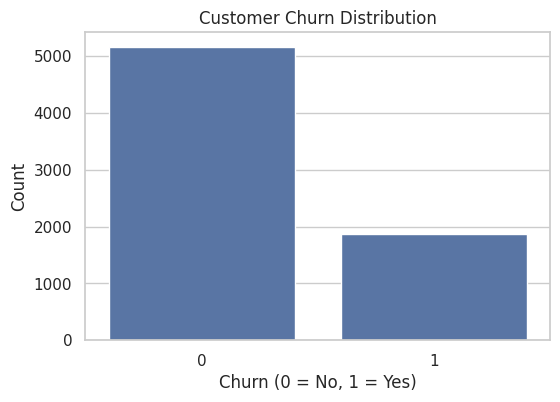

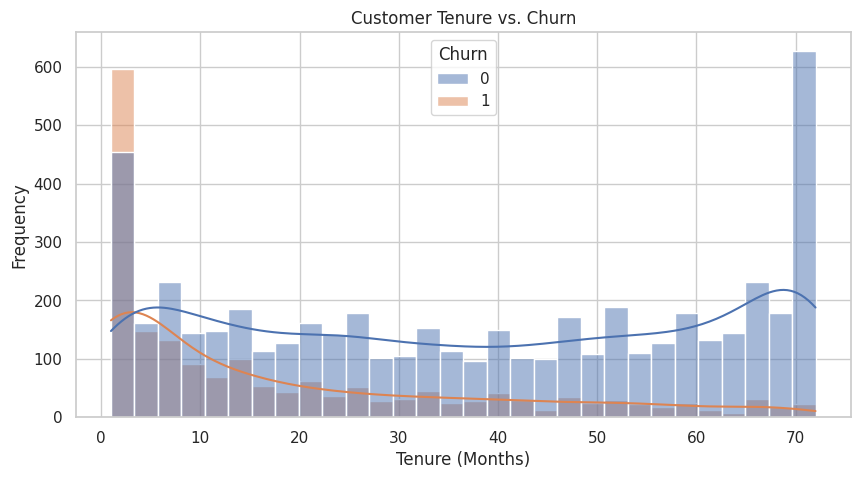

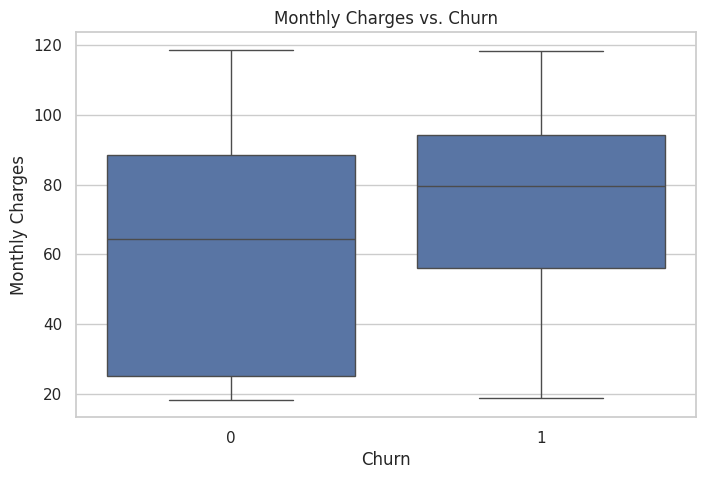

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: EDA + Visual Insights

sns.set(style="whitegrid") #theme

#PLot
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title("Customer Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


#Churn by Tenure
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, bins=30)
plt.title("Customer Tenure vs. Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Frequency")
plt.show()

#Box Plot – Monthly Charges vs Churn

plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs. Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()


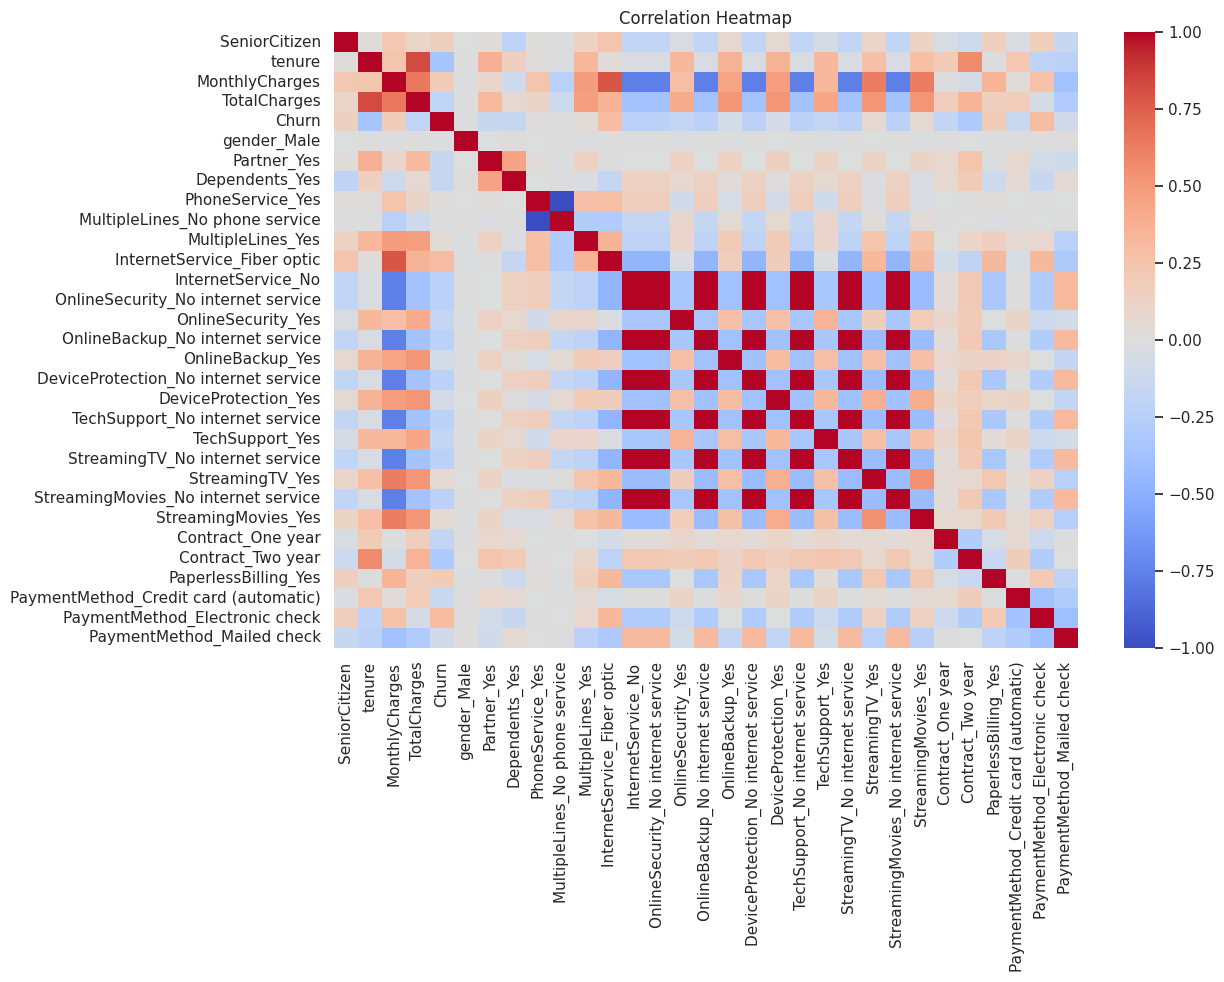

In [10]:
corr = df.drop(columns=['ContractType']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()



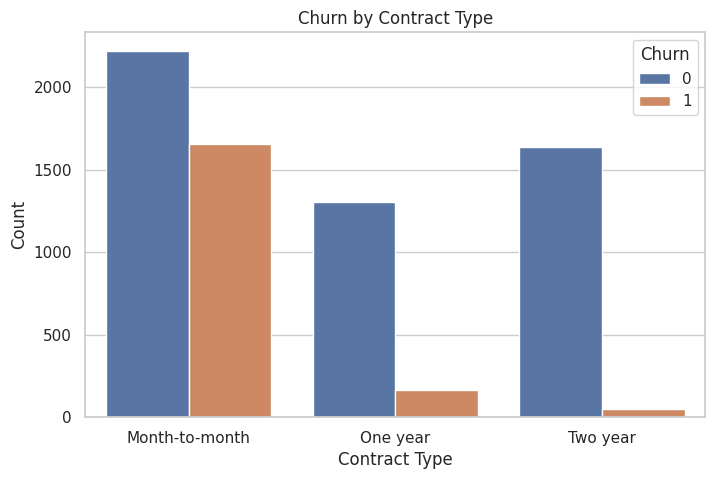

In [18]:
def map_contract(row):
    if row['Contract_One year'] == 1:
        return 'One year'
    elif row['Contract_Two year'] == 1:
        return 'Two year'
    else:
        return 'Month-to-month'

df['ContractType'] = df.apply(map_contract, axis=1)
plt.figure(figsize=(8, 5))
sns.countplot(x='ContractType', hue='Churn', data=df)
plt.title("Churn by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.legend(title="Churn")
plt.show()

In [15]:
#PHASE 3: Model Building & Evaluation
X_train.select_dtypes(include='object').columns

X = df.drop(['Churn', 'ContractType'], axis=1)
y = df['Churn']

# Split again after dropping
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

Accuracy: 0.8031272210376688

Confusion Matrix:
 [[916 117]
 [160 214]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



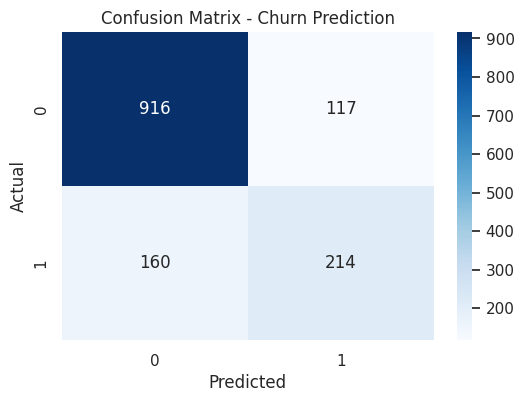

In [16]:
from sklearn.model_selection import train_test_split

# Predict
y_pred = model.predict(X_test)

#Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Visualize the Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Churn Prediction')
plt.show()


Accuracy: 0.7896233120113717

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



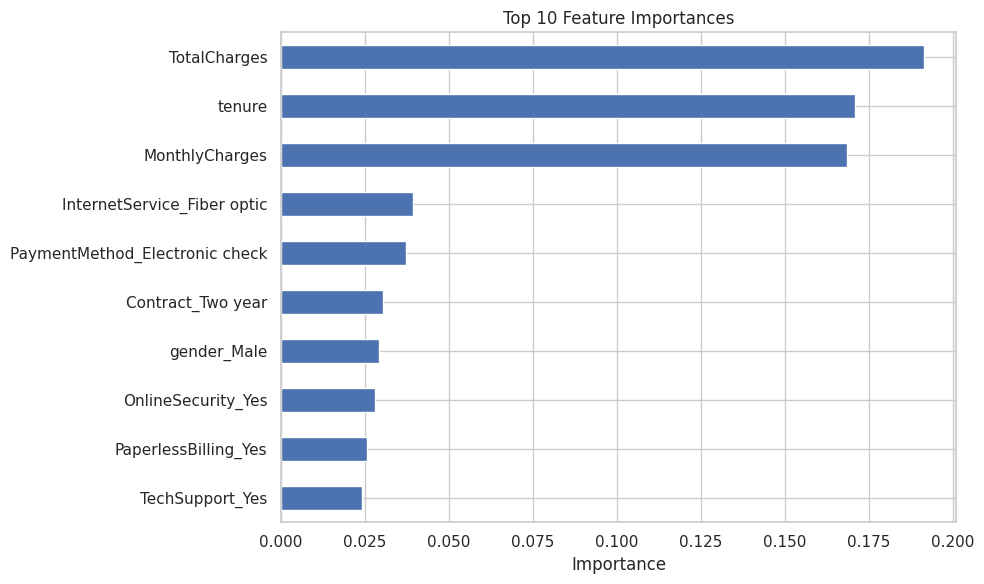

In [17]:
#PHASE 4: Model Improvement + Feature Importance + Export

from sklearn.ensemble import RandomForestClassifier

#Train a Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)

#Evaluate the Random Forest
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

#Plot Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
importances = rf_model.feature_importances_
features = X.columns

# Sort and plot
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importance.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save predictions to CSV (if needed)
output = pd.DataFrame({'Actual': y_test, 'Predicted': rf_pred})
output.to_csv('churn_predictions.csv', index=False)
